# 使用字符级RNN分类名称

[![](https://gitee.com/mindspore/docs/raw/master/resource/_static/logo_source.png)](https://gitee.com/mindspore/docs/blob/master/tutorials/source_zh_cn/middleclass/text/rnn_classification.ipynb)

RNN即循环神经网络，常用于NLP领域当中来解决序列化数据的建模问题。本教程为“从零开始的NLP”第一篇，我们将建立和训练基本的字符级RNN模型对单词进行分类，以帮助用户理解该网络。

字符级RNN将单词作为一系列字符来读取，在每个步骤输出预测，隐藏此时的状态并输入到下一步中。 我们将最终的预测作为输出，该输出用来表示单词属于哪个类别。本实验中，我们将训练来自18种语言的数千种姓氏，并根据拼写方式预测名称的来源：

```bash
$ python predict.py Hinton
(-0.47) Scottish
(-1.52) English
(-3.57) Irish

$ python predict.py Schmidhuber
(-0.19) German
(-2.48) Czech
(-2.68) Dutch

```

## 环境配置

我们使用`PyNative`模式运行实验，使用GPU环境。

In [1]:
from mindspore import context
context.set_context(mode=context.PYNATIVE_MODE, device_target="GPU")

## 准备数据

点击[这里](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/datasets/middleclass/data.zip)下载数据，并将其提取到当前目录。

`data/names`目录中包含 18 个文本文件，名称为`[Language].txt`。 每个文件包含一系列名称，每行一个名称，大多数是罗马音，我们需要将其从Unicode转换为ASCII。

转换之后我们将得到一个字典，其中列出了每种语言的名称列表`{language: [names ...]}`。 通用变量为“category”和“line”，代表语言种类及名称。

In [2]:
from io import open
import glob
import os
import warnings
import unicodedata
import string
warnings.filterwarnings('ignore')

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Unicode转化为ASCII
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# 建立category_lines dictionary
category_lines = {}
all_categories = []

# 读文件并且分列
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names/Japanese.txt', 'data/names/Chinese.txt', 'data/names/Polish.txt', 'data/names/Scottish.txt', 'data/names/Vietnamese.txt', 'data/names/Czech.txt', 'data/names/Portuguese.txt', 'data/names/Dutch.txt', 'data/names/Greek.txt', 'data/names/French.txt', 'data/names/Arabic.txt', 'data/names/Russian.txt', 'data/names/Spanish.txt', 'data/names/Korean.txt', 'data/names/English.txt', 'data/names/Italian.txt', 'data/names/German.txt', 'data/names/Irish.txt']
Slusarski


现在我们有了`category_lines`字典，可以将每个`category`（语言种类）映射到`line`（名称）。在这个过程中同步建立了语言列表`all_categories`和语言数量`n_categories`，用于后续的处理。

In [3]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


## 将名称转换为向量

现在需要将名称转变为向量。

为了表示单个字母，我们使用大小为`<1 x n_letters>`的one-hot向量。one-hot向量用0填充，但当前字母的索引处的数字为1，例如 `"b" = <0 1 0 0 0 ...>`。

为了组成单词，我们将其中的一些向量连接成2D矩阵`<line_length x 1 x n_letters>`。

In [4]:
import numpy as np
from mindspore import Tensor
from mindspore import dtype as mstype

# 查找字母索引，例如"a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# 将字母变为 <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = Tensor(np.zeros((1, n_letters)),mstype.float32)
    tensor[0,letterToIndex(letter)] = 1.0
    return tensor

# 将一行转化为<line_length x 1 x n_letters>，或者array形式的one-hot向量
def lineToTensor(line):
    tensor = Tensor(np.zeros((len(line), 1, n_letters)),mstype.float32)
    for li, letter in enumerate(line):
        tensor[li,0,letterToIndex(letter)] = 1.0
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').shape)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0.]]
(5, 1, 57)


## 创建网络

创建的RNN网络只有两个线性层，它们在输入和隐藏状态下运行，在线性层的输出之后是`LogSoftmax`层。网络结构如图中所示。

![rnn](images/run1.png)

In [5]:
import mindspore.nn as nn
import mindspore.ops as ops
class RNN(nn.Cell):
    
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Dense(input_size + hidden_size, hidden_size)
        self.i2o = nn.Dense(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(axis=1)

    def construct(self, input, hidden):
        op = ops.Concat(axis=1)
        combined = op((input, hidden))
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return Tensor(np.zeros((1, self.hidden_size)),mstype.float32)

       
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

在运行网络之前，我们需要输入代表当前字母的向量，以及先前的隐藏状态。这里将隐藏状态初始化为0。在运行过程中，可以返回属于每种语言的概率和下一个隐藏状态。

In [6]:
input = letterToTensor('A')
hidden =Tensor(np.zeros((1, n_hidden)),mstype.float32)

output, next_hidden = rnn(input, hidden)


为了提高效率，避免在每一步中都创建一个新向量，因此将使用`lineToTensor`而不是`letterToTensor`，同时也采取切片操作。

In [7]:
input = lineToTensor('Albert')
hidden = Tensor(np.zeros((1, n_hidden)),mstype.float32)

output, next_hidden = rnn(input[0], hidden)
print(output)

[[-2.8951542 -2.8894851 -2.89519   -2.9023316 -2.88667   -2.8859577
  -2.8895268 -2.8953846 -2.8703299 -2.8869376 -2.8837688 -2.8951073
  -2.8964722 -2.898948  -2.8797808 -2.8864856 -2.885134  -2.9046268]]


可以看到，输出为`<1 x n_categories>`形式的向量，其中每个数字都代表了分类的可能性。

## 训练

### 准备训练

在接受训练之前，需要一些前处理工作。这里使用`ops.TopK`获得网络输出的最大值，也就是最靠近类别的可能性。

In [8]:
def categoryFromOutput(output):
    topk = ops.TopK(sorted=True)
    top_n, top_i = topk(output,1)
    category_i = top_i.asnumpy().item(0)
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Greek', 8)


我们还将希望有一种快速的方法来获取训练示例，包括名称及其所属的语言类别。

In [9]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = Tensor([all_categories.index(category)], mstype.int32)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)


category = Russian / line = Avdulov
category = Spanish / line = Puerta
category = Polish / line = Kowalczyk
category = Arabic / line = Hakimi
category = Scottish / line = Miller
category = Vietnamese / line = Thai
category = Czech / line = Kacirek
category = Portuguese / line = Ferreiro
category = Vietnamese / line = Do
category = Polish / line = Fabian


### 训练网络

可以通过大量数据来进行网络训练。由于网络的最后一层是`nn.LogSoftmax`，所以采用`NLLLoss`来作为损失函数。

In [10]:
import mindspore.ops as ops
from mindspore.nn.loss import Loss

class NLLLoss(Loss):
    def __init__(self, reduction='mean'):
        super(NLLLoss, self).__init__(reduction)
        self.one_hot = ops.OneHot()
        self.reduce_sum = ops.ReduceSum()
    def construct(self, logits, label):
        label_one_hot = self.one_hot(label, ops.shape(logits)[-1], ops.ScalarToArray(1.0), ops.ScalarToArray(0.0))
        loss = self.reduce_sum(-1.0 * logits * label_one_hot, (1,))
        return self.get_loss(loss)

In [11]:
criterion = NLLLoss()

每个训练循环将：

- 创建输入和目标向量
- 创建归零的初始隐藏状态
- 阅读每个字母并保存下一个字母的隐藏状态
- 比较最终输出与目标值
- 反向传播
- 返回输出和损失

In [12]:
from mindspore import nn, ops, context

class WithLossCellRnn(nn.Cell):
    def __init__(self, backbone,loss_fn):
        super(WithLossCellRnn, self).__init__(auto_prefix=True)
        self._backbone = backbone
        self._loss_fn = loss_fn

    def construct(self, line_tensor, hidden, category_tensor):
        for i in range(line_tensor.shape[0]):
            output, hidden = self._backbone(line_tensor[i], hidden)
        return self._loss_fn(output, category_tensor)

In [13]:
from mindspore import ParameterTuple
rnn_cf = RNN(n_letters, n_hidden, n_categories)
optimizer = nn.Momentum(filter(lambda x:x.requires_grad,rnn_cf.get_parameters()),0.001,0.9)
net_with_criterion = WithLossCellRnn(rnn_cf, criterion)
net = nn.TrainOneStepCell(net_with_criterion, optimizer)
net.set_train()
def train(category_tensor, line_tensor):
    hidden = rnn_cf.initHidden()
    loss = net(line_tensor,hidden,category_tensor)
    for i in range(line_tensor.shape[0]):
        output, hidden = rnn_cf(line_tensor[i], hidden)
    return  output, loss

下面进行模型训练。通过`print_every`，每隔500个样本打印一次。通过✓、✗来表示每个节点上模型判断的正误。

In [14]:
import time
import math

n_iters = 10000
print_every = 500
plot_every = 100

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()
for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # 根据迭代打印loss、对应的name和预测值
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %s %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss.asnumpy(), line, guess, correct))

    # 将当前loss添加至all_losses
    if iter % plot_every == 0:
        all_losses.append((current_loss / plot_every).asnumpy())
        current_loss = 0

500 5% (0m 55s) 2.9511454 Mai / Italian ✗ (Vietnamese)
1000 10% (1m 39s) 2.7946725 Timonnikov / Portuguese ✗ (Russian)
1500 15% (2m 23s) 2.581205 Morandi / Polish ✗ (Italian)
2000 20% (3m 4s) 2.7694151 Ceallachan / Vietnamese ✗ (Irish)
2500 25% (3m 47s) 2.8895192 Bairamkuloff / Polish ✗ (Russian)
3000 30% (4m 29s) 3.07459 Sarkozi / Italian ✗ (French)
3500 35% (5m 10s) 2.8098087 Mcnab / Chinese ✗ (Irish)
4000 40% (5m 53s) 2.1731405 Arlotti / Italian ✓
4500 45% (6m 35s) 3.2535906 De laurentis / Greek ✗ (Italian)
5000 50% (7m 19s) 2.6969473 O'Neal / Irish ✓
5500 55% (7m 59s) 3.0052674 Fabian / Scottish ✗ (French)
6000 60% (8m 42s) 2.9978802 Chi / Italian ✗ (Korean)
6500 65% (9m 24s) 1.4152222 Hagias / Greek ✓
7000 70% (10m 7s) 2.5804625 Malouf / Arabic ✓
7500 75% (10m 48s) 2.615438 Reid / Scottish ✓
8000 80% (11m 31s) 2.6654413 O'Boyle / French ✗ (Irish)
8500 85% (12m 14s) 3.0208545 Wruck / Polish ✗ (German)
9000 90% (12m 55s) 1.734647 Wojewodzki / Polish ✓
9500 95% (13m 38s) 2.5977328 Da

### 绘制结果

从`all_losses`绘制历史损失可显示网络学习情况。

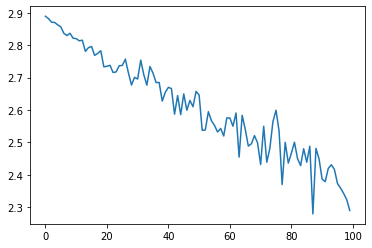

In [15]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()

plt.plot(all_losses)

## 评估结果

为了查看网络在不同类别上的表现如何，我们将创建一个混淆矩阵，行坐标为实际语言，列坐标为预测的语言。 为了计算混淆矩阵，使用`evaluate()`通过RNN网络运行样本，这一过程相当于在`train()`时不进行反向传播。

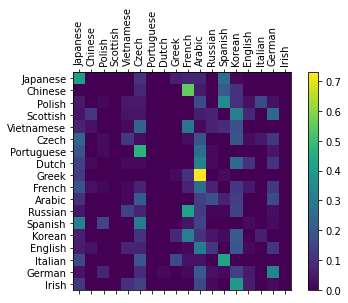

In [16]:
# 在混淆矩阵中记录正确预测
confusion = Tensor(np.zeros((n_categories, n_categories)), mstype.float32)
n_confusion = 1000

# 获取每行的输出
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.shape[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# 运行样本，并记录正确的预测
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i,guess_i] += 1

# 标准化输出
for i in range(n_categories):
    confusion[i] = confusion[i] / np.sum(confusion[i])

# 绘制图表
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.asnumpy())
fig.colorbar(cax)

# 设定轴
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# 在坐标处添加标签
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

## 自定义输入

下面用户可以选择几个名称，通过RNN网络进行预测。

In [17]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    
    output = evaluate(lineToTensor(input_line))

    # Get top N categories
    topk = ops.TopK(sorted=True)
    top_n, top_i = topk(output,3)
    predictions = []

    for i in range(n_predictions):
        value = top_n.asnumpy()[0][i].item()
        category_index = top_i.asnumpy()[0][i].item()
        print('(%.2f) %s' % (value, all_categories[category_index]))
        predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-2.88) Vietnamese
(-2.88) Chinese
(-2.88) Arabic

> Jackson
(-2.87) Korean
(-2.88) Irish
(-2.88) German

> Satoshi
(-2.88) Spanish
(-2.88) Greek
(-2.88) Japanese
